## 如果不太熟悉CNN，推荐看一下下面链接，可以只看视频，看完后用这个Notebook自己写一个Transfer Learning，和全部的CNN

https://www.kaggle.com/learn/deep-learning

In [30]:
# import section, basic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
data_dir = 'data'
test_dir = os.path.join(data_dir, 'test.csv')
train_dir = os.path.join(data_dir, 'train.csv')

In [80]:
# 读取dataframe data
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)

In [105]:
# 分离label和images
train_Y = train_df['label']
train_X = train_df.drop('label',axis=1)
train_X = np.reshape(np.array(train_X), (-1, 28, 28))
train_X = train_X/255
train_X = np.array(
    [np.stack((x, x, x), axis=2) for x in train_X]
)

(42000, 28, 28, 3)

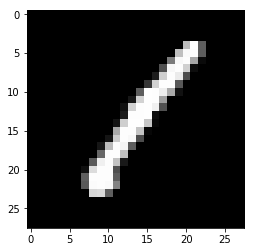

In [110]:
# 图像没有变，但是增加了三个channel，变味了resnet50接受的rgb格式图片
display(train_X.shape)
plt.imshow(train_X[0])

## Transfer Learning

#### Transfer Learning 的意思就是借用了别人train好的weights, 自己再根据这个dataset在最后添加一层prediction layer 

我用的model可以在这个链接下载，链接里面也给了这个model包含的layers说明
https://www.kaggle.com/keras/resnet50#resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [44]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
t_model = Sequential() # 建立我们的transfer model
#把别人训练好的weights和model加进去，这里我们把top layer去掉了
t_model.add(ResNet50(include_top=False, pooling='avg', weights=weights_path)) 
t_model.add(Dense(10, activation='softmax'))
t_model.layers[0].trainable=False

categorical_crossentropy:https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/categorical-crossentropy


Adam optimizer
https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c

In [108]:
# compile model
from keras.utils.np_utils import to_categorical
from keras.losses import categorical_crossentropy
train_Y = to_categorical(train_Y, num_classes=10) # one-hot 我们的labels
# 虽然前面几层都train好了，我们还是要compile我们的model再fit
t_model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

Batch size 和 epochs的含义：
https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

简单来说，batch size代表了一次性传进去多少张图片，epochs代表了总共train所有data多少次

In [111]:
t_model.fit(train_X, train_Y, batch_size=100, epochs=2, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/2
33600/33600 [==============================] - 99s 3ms/sample - loss: 0.5893 - acc: 0.8196 - val_loss: 1.5385 - val_acc: 0.5161
Epoch 2/2
33600/33600 [==============================] - 99s 3ms/sample - loss: 0.5245 - acc: 0.8368 - val_loss: 0.5386 - val_acc: 0.8383


可以看到我们的transer learning出来的model第一遍epoch在training data中达到了 81%的accuracy， 在validation data中只有 51%， 第二遍epoch后 validation 也有了83.83，如果想要更加好的数字，我们在合理范围内可以调小batch_size，增大epochs，可以自己都试试，但是最后的结果变化应该不会太大了。Resnet50其实并不是很合适我们的dataset，因为它本来是用在更加复杂的，彩色的图片里，我们用它有些大材小用了，并且也不是很合适。后面的code会自己train一个model，它的accuracy会更加高一些

## Scratch CNN

In [131]:
# 重新读取dataframe data 并且resize and one-hot
train_df = pd.read_csv(train_dir)
test_df = pd.read_csv(test_dir)
train_Y = train_df['label']
train_X = train_df.drop('label',axis=1)
train_X = np.reshape(
    np.array(train_X),
    (-1, 28, 28, 1)
)
train_X = train_X/255
train_Y = to_categorical(train_Y, num_classes=10)

In [132]:
model = Sequential() # 同样还是Sequential

In [133]:
from tensorflow.python.keras.layers import Dense, Conv2D, Flatten

In [134]:
# 加入input layer, 因为是input所以要加input_shape
model.add(Conv2D(filters=16, 
                 kernel_size=(5,5),
                 activation='relu',
                 input_shape=(28, 28, 1)))

Conv2D: 
https://www.saama.com/different-kinds-convolutional-filters/

Filters:
https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function

relu:
https://medium.com/@danqing/a-practical-guide-to-relu-b83ca804f1f7

In [135]:
# 加入后续的Conv2D
model.add(Conv2D(filters=32, 
                 kernel_size=(5,5),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(filters=64, 
                 kernel_size=(5,5),
                 activation='relu',
                 ))

In [136]:
# 加入flatten，把2d变成1d， 紧跟一个dense
model.add(Flatten())
model.add(Dense(128, activation='relu'))

In [137]:
# 加入softmax最后的预测
model.add(Dense(10, activation='softmax'))

In [138]:
# comile and fit
model.compile(loss=categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_Y, batch_size=100, epochs=4, validation_split=0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/4
33600/33600 [==============================] - 76s 2ms/sample - loss: 0.1720 - acc: 0.9471 - val_loss: 0.0641 - val_acc: 0.9801
Epoch 2/4
33600/33600 [==============================] - 77s 2ms/sample - loss: 0.0484 - acc: 0.9848 - val_loss: 0.0444 - val_acc: 0.9875
Epoch 3/4
33600/33600 [==============================] - 75s 2ms/sample - loss: 0.0314 - acc: 0.9902 - val_loss: 0.0415 - val_acc: 0.9876
Epoch 4/4
33600/33600 [==============================] - 76s 2ms/sample - loss: 0.0218 - acc: 0.9931 - val_loss: 0.0436 - val_acc: 0.9881


但是我们如果看高赞notebook里，https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

除开Conv2D，Dense以外还用到了Maxpool， 和Dropout，这两个layer都是用来防止我们的model overfitting，两个layer都很好理解，下面的链接解释他们的作用

Maxpool: 
https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks

Dropout:
https://medium.com/@amarbudhiraja/https-medium-com-amarbudhiraja-learning-less-to-learn-better-dropout-in-deep-machine-learning-74334da4bfc5

自己train的model accuracy比transfer learning高了很多，到最后一个epoch 的validation accuracy已经逼近100%了，但是我们到现在都还没有碰过原数据里面的test data，我们的model很可能存在over fitting。